# Deep Convolutional GAN (DCGAN)

Trong bài toán này, ta sẽ tạo một GAN model khác bằng cách sử dụng tập dữ liệu MNIST. Ta sẽ triển khai DCGAN, một mô hình GAN rất thành công và có ảnh hưởng rất lớn được phát triển vào năm 2015.[paper](https://arxiv.org/pdf/1511.06434v1.pdf)

![Generator architecture](dcgan-gen.png)

                                        Hình 1: Kiến trúc bộ generator của DCGAN

## DCGAN
Dưới đây là các đặc trưng chính của DCGAN:

* Thay thế pooling layers bằng strided convolutions (discriminator) và fractional-strided convolutions (generator).
* Sử dụng BatchNorm trong cả hai generator và discriminator.
* Loại bỏ các lớp fully connected.
* Sử dụng ReLU activation trong generator cho tất cả layers ngoại trừ lớp output sử dụng actovation Tanh.
* Sử dụng LeakyReLU activation trong discriminator cho tất cả layers, ngoại trừ output không sử dụng activation

In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) #

## Generator

Thành phần đầu tiên ta sẽ làm là Generator. Ta có thể nhận thấy rằng thay vì truyền kích thước của hình ảnh như trong GAN basic, ta sẽ chuyển số kênh hình ảnh cho generator. Điều này là do với DCGAN, ta sử dụng các convolutions không phụ thuộc vào số lượng pixel trên hình ảnh, số lượng kênh rất quan trọng để xác định kích thước của các bộ lọc.

Ta sẽ xây dựng generator với 4 layer (3 hidden layers + 1 output layer).Ta sẽ viết một function để tạo một single block cho mạng nơ-ron của generator.

Vì trong DCGAN, chức năng kích hoạt sẽ khác đối với lớp đầu ra, do vậy ta sẽ cần kiểm tra xem lớp nào đang được tạo. 

Ở cuối của Generator class, ta sử dụng hàm forward lấy véc tơ nhiễu và tạo ra hình ảnh với kích thước đầu ra bằng với hình ảnh MNIST. Ta cũng sẽ có một function để tạo một vector nhiễu.

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: chiều của vector noise, một đại lượng vô hướng
        im_chan: số kênh của hình ảnh đầu ra, một đại lượng vô hướng
              (MNIST là ảnh đen trắng, vì vậy 1 kênh là mặc định )
        hidden_dim: kích thước bên trong, một đại lượng vô hướng
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Xây dựng neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Hàm trả về một chuỗi các hoạt động tương ứng với một block của DCGAN, 
        đó là một transposed convolution, 
        một batchnorm (ngoại trừ ở lớp cuối cùng) và một kích hoạt.
        Parameters:
            input_channels: kích thước đầu vào
            output_channels: kích thước đầu ra
            kernel_size: kích thước của mỗi bộ lọc convolution, tương đương với (kernel_size, kernel_size)
            stride: kích thước sải bước của bộ lọc trên đầu vào
            final_layer: boolean, true nếu nó là lớp cuối cùng và false nếu không
        '''
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def unsqueeze_noise(self, noise):
        '''
        Cho một noise tensor, trả về một bản sao của noise đó 
        với width and height = 1 và các kênh = z_dim.
        Parameters:
            noise: Một tensor noise với shape (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Cho một noise tensor, thực hiện bước forward và
        trả về hình ảnh được tạo
        Parameters:
            noise: Một tensor noise với shape (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Hàm tạo noise tensor: Cho shape (n_samples, z_dim)
    tạo ra một tensor theo shape đó với các giả trị được random từ nornal distribution.
    Parameters:
        n_samples: số lượng mẫu cần tạo, một đại lượng vô hướng
        z_dim: chiều của vector noise, một đại lượng vô hướng
        device: "cpu" or "cuda"
    '''
    return torch.randn(n_samples, z_dim, device=device)

## Discriminator
Thành phần thứ hai ta cần thực hiện là Discriminator. Ta sẽ sử dụng 3 layer trong mạng nơ-ron của Discriminator. Giống như với Generator, ta một hàm để tạo một single block cho Discriminator.

In [3]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: số kênh của hình ảnh đầu ra, một dại lượng vô hướng
              (MNIST ảnh màu đen trắng, vì vậy 1 kênh là mặc định )
    hidden_dim: kích thước bên trong, một đại lượng vô hướng
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Hàm trả về một chuỗi các hoạt động tương ứng với một block disc của DCGAN, 
        đó là một convolution, một batchnorm (ngoại trừ ở lớp cuối cùng) và một kích hoạt.
        Parameters:
            input_channels: kích thước đầu vào
            output_channels: kích thước đầu ra
            kernel_size: kích thước của mỗi bộ lọc convolution, tương đương với (kernel_size, kernel_size)
            stride: kích thước sải bước của bộ lọc trên đầu vào
            final_layer: boolean, true nếu nó là lớp cuối cùng và false nếu không
        '''        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Hàm thực hiện forward của discriminator: Cho một image tensor, 
        trả về tensor 1 chiều tương ứng với đó là real hay fake.
        Parameters:
            image: a flatten image tensor với số chiều (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Training
Bây giờ ta có thể đặt tất cả lại với nhau và thực hiện quá trình training

  *   criterion: loss function
  *   n_epochs: số lần lặp qua toàn bộ tập dataset
  *   z_dim: chiều của vector noise
  *   display_step: sau bao step sẽ hiển thị kết quả image
  *   batch_size: số lượng image để thực hiện 1 lần forward/backward
  *   lr: learning rate
  *   beta_1, beta_2: parameter cho Adam optimizer
  *   device: "cuda"

In [4]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# Chuyển đổi các giá trị hình ảnh thành từ -1 đến 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Load MNIST dataset
dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Sau đó khởi tạo generator, discriminator, and optimizers.

In [5]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# Khởi tạo trọng số theo phân phối chuẩn với mean=0 và std=0,02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

function sau đây để trực quan hóa kết quả sau mỗi display_step steps.

In [6]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Cho một tensor image, số lượng hình ảnh 
    và kích thước mỗi hình ảnh, plot hình ảnh trong một grid đồng nhất.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Cuối cùng, ta có thể đào tạo GAN của mình! Đối với mỗi epoch, ta sẽ xử lý toàn bộ tập dữ liệu theo batch. Đối với mỗi batch, sẽ cập nhật discriminator và generator. Sau đó, plot kết quả sau 500 steps để xem liệu Generator có thể tạo ra image là các số giống với ảnh thật theo thời gian hay không.

Step 500: Generator loss: 0.8524149307012561, discriminator loss: 0.5437961188554762


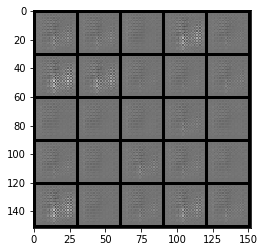

Step 1000: Generator loss: 2.063477059245109, discriminator loss: 0.18518842583894723


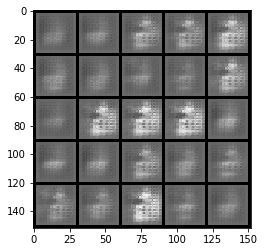

Step 1500: Generator loss: 1.6608989909291263, discriminator loss: 0.3821241177022457


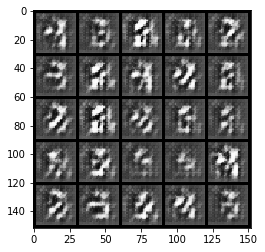

Step 2000: Generator loss: 1.2921725738197567, discriminator loss: 0.4916403485834602


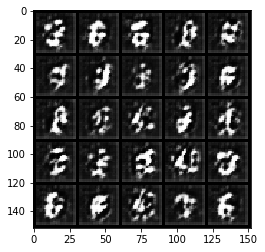

Step 2500: Generator loss: 1.038794573456049, discriminator loss: 0.555002275466919


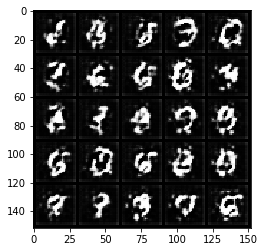

Step 3000: Generator loss: 0.9193250424861908, discriminator loss: 0.593547766089439


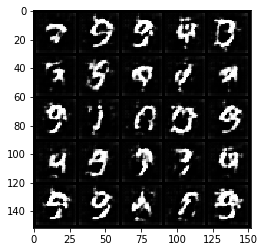

Step 3500: Generator loss: 0.832480028688908, discriminator loss: 0.6233074960708621


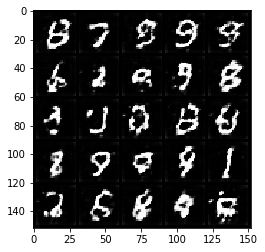

Step 4000: Generator loss: 0.8016763936281208, discriminator loss: 0.6392074964046488


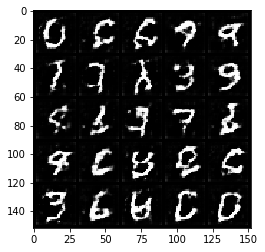

Step 4500: Generator loss: 0.7985787784457208, discriminator loss: 0.6476401919126518


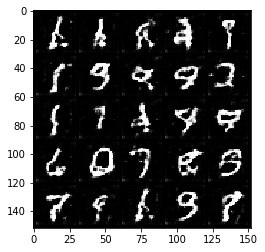

Step 5000: Generator loss: 0.7775325190424925, discriminator loss: 0.6607845305204392


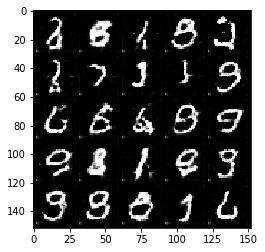

Step 29000: Generator loss: 34.19417068481426, discriminator loss: 33.26571553921708


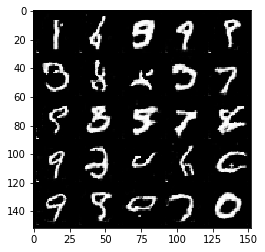

Step 29500: Generator loss: 0.6976458932161329, discriminator loss: 0.6943185089826582


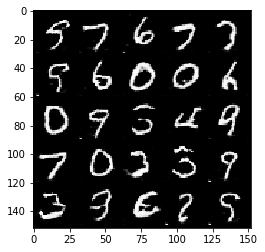

Step 30000: Generator loss: 0.6974693473577501, discriminator loss: 0.6940474112033845


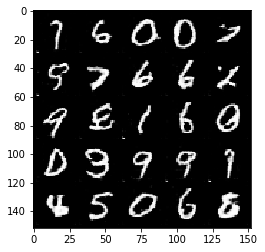

Step 30500: Generator loss: 0.6980360078811646, discriminator loss: 0.6941823272705081


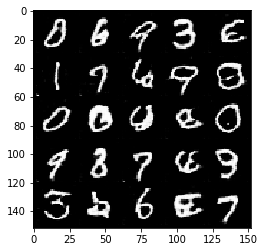

Step 31000: Generator loss: 0.6967207227945328, discriminator loss: 0.6942521917819977


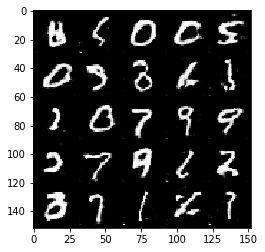

Step 31500: Generator loss: 0.6971622797250745, discriminator loss: 0.6942090830802924


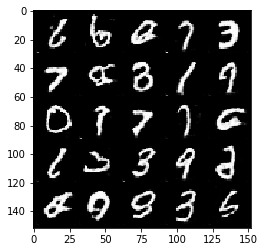

Step 32000: Generator loss: 0.6970761361122133, discriminator loss: 0.6943043584823617


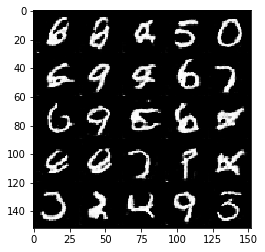

Step 32500: Generator loss: 0.6964763478040691, discriminator loss: 0.6938942966461188


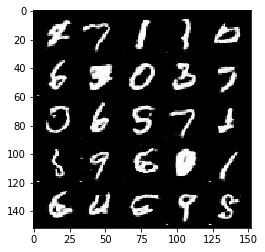

Step 33000: Generator loss: 0.6973504719734189, discriminator loss: 0.694184133529663


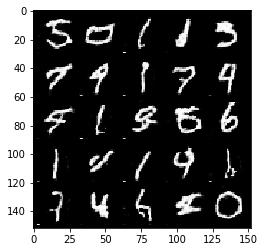

Step 33500: Generator loss: 0.6961207911968228, discriminator loss: 0.6941241247653968


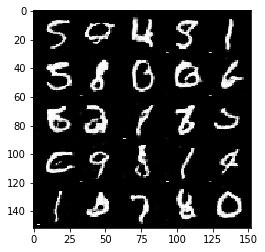

Step 34000: Generator loss: 0.6961342051029209, discriminator loss: 0.6943318698406227


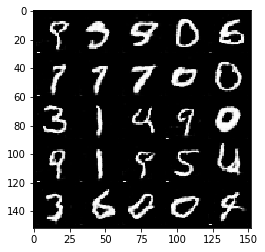

Step 34500: Generator loss: 0.6958600786924363, discriminator loss: 0.6940637626647949


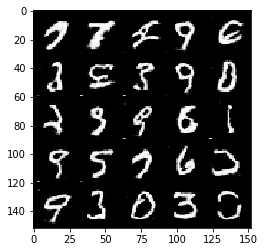

Step 35000: Generator loss: 0.6959661502838131, discriminator loss: 0.6941894052028652


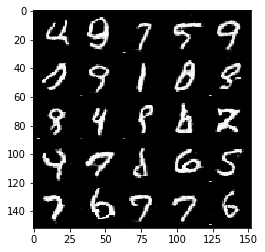

Step 35500: Generator loss: 0.6956120053529739, discriminator loss: 0.6939742361307144


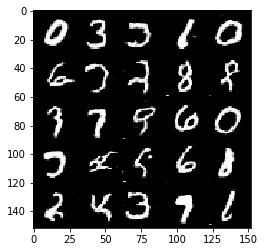

Step 36000: Generator loss: 0.6952297337055211, discriminator loss: 0.6940601838827137


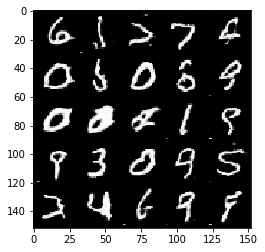

Step 36500: Generator loss: 0.6959912722110745, discriminator loss: 0.6940061126947406


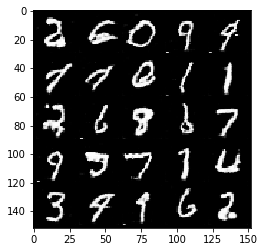

Step 37000: Generator loss: 0.6958899974822997, discriminator loss: 0.6941113553047172


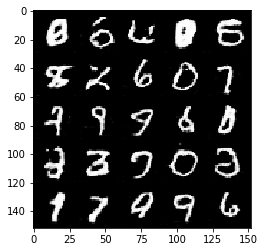

Step 37500: Generator loss: 0.6949260482788086, discriminator loss: 0.6938141746520996


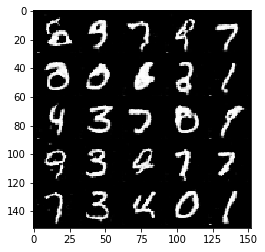

Step 38000: Generator loss: 0.6955341501235958, discriminator loss: 0.6939888210296633


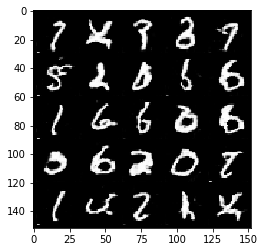

Step 38500: Generator loss: 0.6953815253972999, discriminator loss: 0.6938752485513692


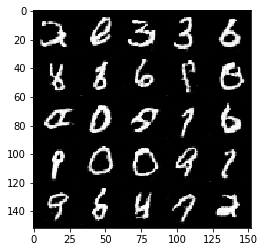

Step 39000: Generator loss: 0.6951471337080002, discriminator loss: 0.6939139118194582


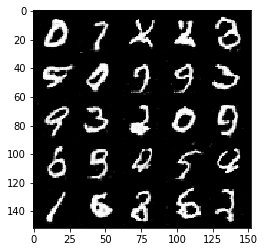

Step 39500: Generator loss: 0.6947904850244523, discriminator loss: 0.6939004595279689


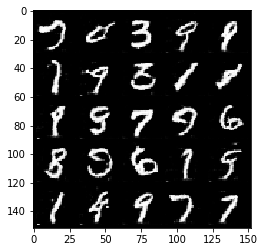

In [7]:
n_epochs = 85
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    # Dataloader trả về các batch image
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # theo dõi average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # theo dõi average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and 0 < cur_step < 5500:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            #show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        elif cur_step % display_step == 0 and cur_step > 28500:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            #show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

Ta có thể nhận thấy rằng trong hình ảnh của Step 30000, Generator đang tạo ra những chữ số trông giống hệt với những chữ số trong tập dataset. Nếu Discriminator không học cách phân loại hình ảnh đâu là real hay fake, thì Generator có thể tạo ra nhiều hình ảnh giống thật hơn nữa. Kết quả là, Generator có thể đã đánh lừa Discriminator tốt đến mức khiến cho Discriminator phân loại ảnh fake do Generator tạo ra là ảnh real.